In [1]:
import os

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import PercentFormatter

# Exploratory Data Analysis

The last notebook was responsible for downloading the [Kaggle's São Paulo House Price dataset](https://www.kaggle.com/datasets/ex0ticone/house-prices-of-sao-paulo-city), filter irrelevant data (rentals, outliers) and saving it to ".parquet", a more convenient file format.

In this notebook, we will perform an Exploratory Data Analysis (EDA) of our dataset. Our goal is to get a better understanding of the dataset and identify any patterns or correlations between the features and the target variable (the house price). We will use various visualization techniques and statistical methods to explore the data and gain insights.

## Dataset Loading

Lets load our already processed dataset and check it.

In [2]:
processed_dataset_root_dir = os.path.join(os.path.dirname(os.path.abspath("")), "data", "processed")

In [3]:
sp_house_price = pd.read_parquet(os.path.join(processed_dataset_root_dir, "sp_sales_data.parquet"))
sp_house_price

,bairro,tipo_imovel,area_util,banheiros,suites,quartos,vagas_garagem,anuncio_criado,preco_venda,taxa_condominio,iptu_ano
0,Jardim da Saude,Casa de dois andares,388.0,3.0,1.0,4.0,6.0,2017-02-07,700000,NaN,NaN
1,Vila Santa Teresa (Zona Sul),Casa,129.0,2.0,1.0,3.0,2.0,2016-03-21,336000,NaN,NaN
2,Vila Olimpia,Apartamento,80.0,2.0,1.0,3.0,2.0,2018-10-26,739643,686.0,1610.0
3,Pinheiros,Apartamento,94.0,1.0,0.0,3.0,2.0,2018-05-29,630700,1120.0,489.0
4,Vila Santa Clara,Condominio,110.0,1.0,1.0,3.0,2.0,2018-04-16,385000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
88742,Vila Carmosina,Apartamento,48.0,1.0,0.0,2.0,1.0,2017-10-07,171150,244.0,0.0
88743,Bela Vista,Apartamento,60.0,1.0,NaN,1.0,1.0,2017-12-13,251999,273.0,86.0
88744,Liberdade,Apartamento,53.0,2.0,1.0,2.0,1.0,2018-11-28,249782,210.0,0.0
88745,Vila Lageado,Apartamento,20.0,3.0,2.0,3.0,2.0,2019-02-06,623000,NaN,NaN


In [4]:

sp_house_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88747 entries, 0 to 88746
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   bairro           88747 non-null  object        
 1   tipo_imovel      88747 non-null  object        
 2   area_util        87125 non-null  float64       
 3   banheiros        88742 non-null  float64       
 4   suites           80885 non-null  float64       
 5   quartos          88744 non-null  float64       
 6   vagas_garagem    87110 non-null  float64       
 7   anuncio_criado   88747 non-null  datetime64[ns]
 8   preco_venda      88747 non-null  int64         
 9   taxa_condominio  78203 non-null  float64       
 10  iptu_ano         73429 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(2)
memory usage: 7.4+ MB


Our dataset now has 89441 entries and 10 features, including the target feature `preco_venda`. For the feature type we have `bairro` and `tipo_movel` as *objects*, `anuncio_criado` as *datetime*, `preco_venda` as an *integer* and the remaining features as *floats*, but don't let these types misguide you.

First of all, as it's own name sugests, `preco_venda` is in *monetary units* (**Reais** in this case), so it would be wise to consider those values as *floats*, and the decimal places would account for **cents**.

`banheiros`, `suites`, `quartos` and `vagas_garagem` as *floats* doesn't sounds good too. e.g.: 0.75 bathroom doesn't make sense. It's more likely that these features were considered *floats* by Pandas by the occurences of *missing values* in them, as these are represented by `nan` (a float value).

Speaking of *missing values*, they occur in some features. Let's how the features are affected by this.

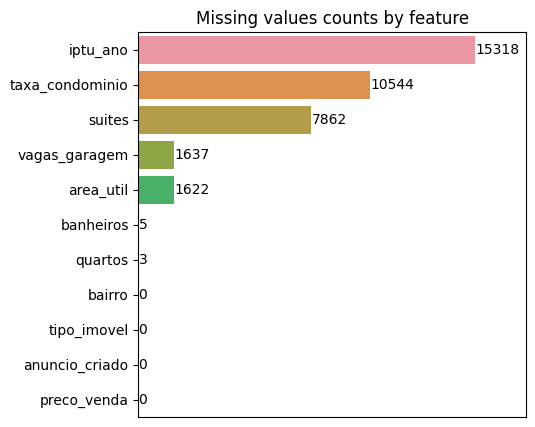

In [5]:
na_counts = sp_house_price.isna().sum(axis="rows").sort_values(ascending=False)

_, ax = plt.subplots(figsize=(5, 5))
sns.barplot(x=na_counts, y=na_counts.index, ax=ax)

for p in ax.patches:
    x = p.get_x()
    y = p.get_y()
    width = p.get_width()
    height = p.get_height()
    ax.annotate(f"{int(width)}", (width + x, y + height * 0.65), ha="left")

ax.set_xlim([0, int(1.15 * na_counts.values[0])])
ax.axes.get_xaxis().set_visible(False)
ax.set_title("Missing values counts by feature");

`iptu_ano` is the feature with most *missing values*, followed by `taxa_condominio` and `suites`. Some of those missing values seems to be erros, as the lack of values would not make sense for `area_util`, `banheiros` and `quartos`. We'll deal with those values after our analysis, that will bring us some insights on how to handle them.

# General Dataset Overview

Let's take a look on some statistics of the dataset's numerical features.

In [6]:
sp_house_price.describe()

,area_util,banheiros,suites,quartos,vagas_garagem,preco_venda,taxa_condominio,iptu_ano
count,87125.000000,88742.000000,80885.000000,88744.000000,87110.000000,8.874700e+04,7.820300e+04,7.342900e+04
mean,113.392562,2.200086,1.062818,2.538267,1.834049,5.483481e+05,9.878045e+02,7.340850e+02
std,68.613846,1.309771,0.986569,0.814964,1.158817,3.735593e+05,2.623275e+04,5.012955e+04
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.050000e+04,0.000000e+00,0.000000e+00
25%,62.000000,1.000000,0.000000,2.000000,1.000000,2.800000e+05,0.000000e+00,0.000000e+00
50%,93.000000,2.000000,1.000000,3.000000,2.000000,4.315500e+05,3.500000e+02,3.700000e+01
75%,149.000000,3.000000,1.000000,3.000000,2.000000,6.805750e+05,6.720000e+02,2.100000e+02
max,397.000000,7.000000,6.000000,5.000000,7.000000,1.931999e+06,4.059999e+06,1.036700e+07


We can see that `banheiros`, `suites`, `quartos` and `vagas_garagem` have indeed low values, so they may be categorical features.

We can also note that `taxa_condominio` and `iptu_ano` have at least 25% of their data set to zero, which is not consistent with their definition. We'll devise an approach to handle this problem later in this notebook.

Now let's take a look at the non-numeric features.

In [7]:
sp_house_price.describe(include="O")

,bairro,tipo_imovel
count,88747,88747
unique,1426,8
top,Santana,Apartamento
freq,2168,59559


`bairro` and `tipo_imovel` are provided in full for this dataset. While `tipo_imovel` has only 8 unique values, possibly representing categories, `bairro` has 1426 values, so this features has a high cardinality.

# Univariate Analysis

Now we'll conduct our analysis by checking each features individually, starting with our target feature.

## preco_venda

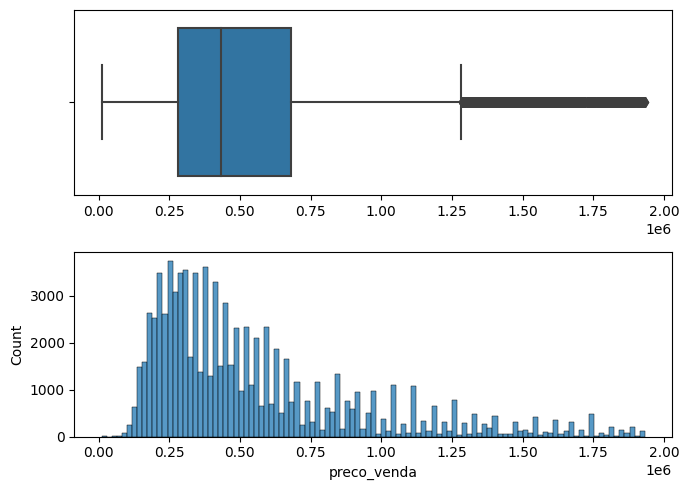

In [8]:
_, (ax1, ax2) = plt.subplots(nrows=2, figsize=(7, 5))
sns.boxplot(x="preco_venda", data=sp_house_price, ax=ax1);
ax1.set_xlabel("")
sns.histplot(x="preco_venda", data=sp_house_price, ax=ax2);

plt.tight_layout()

House Prices ranges from R$10.500,00 to R$1.931.999,00, with average price of R$548.348,00. 50% of the prices are concentrated in range between R$280.000,00 and R$680.575,00. We also have positive skewness, as we can see by the long right tail of the distribution, indicating that we have some high valued **outliers**.

## bairro

`bairro` relates to the neighborhood of the house. In general, due to proximity to interesting places (e.g.: comercial centers, schools, parks, beachs, etc.) and neighborhood development, house prices vary for one neighborhood to another.

Let's take a look to the top-30 neighboors with houses and the least-30 with less houses for sale.

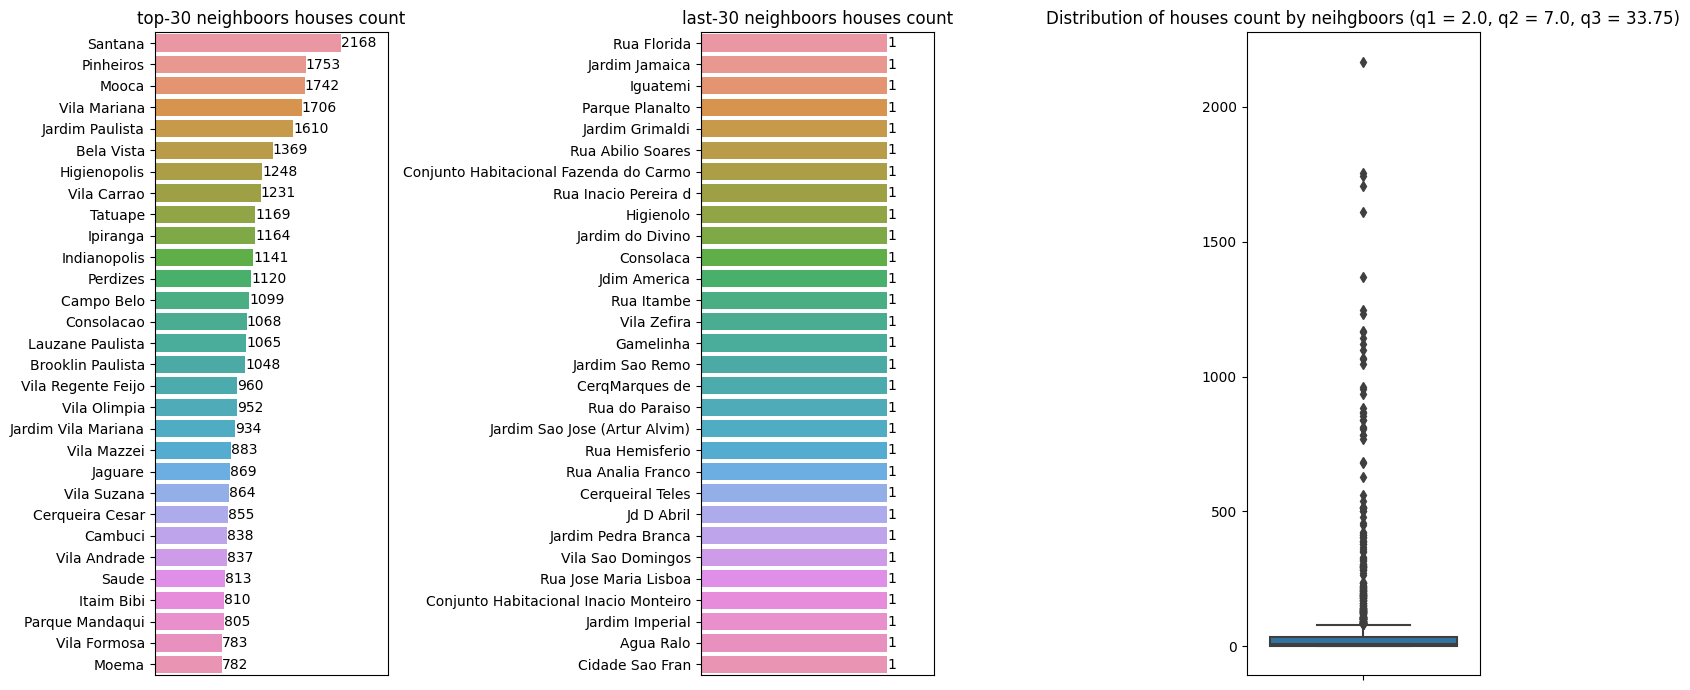

In [9]:
neighs_counts = sp_house_price.bairro.value_counts()

top_30_neighs = neighs_counts.head(30)
last_30_neighs = neighs_counts.tail(30)

titles = ("top-30 neighboors houses count", "last-30 neighboors houses count")

_, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 7))

for title, ax, neighs in zip(titles, (ax1, ax2), (top_30_neighs, last_30_neighs)):
    
    sns.barplot(x=neighs, y=neighs.index, ax=ax)

    for p in ax.patches:
        x = p.get_x()
        y = p.get_y()
        width = p.get_width()
        height = p.get_height()
        ax.annotate(f"{int(width)}", (width + x, y + height * 0.75), ha="left")

    ax.set_xlim([0, 1.25 * neighs.values[0]])
    ax.axes.get_xaxis().set_visible(False)
    ax.set_title(title);

sns.boxplot(y=neighs_counts, ax=ax3)
ax3.set_ylabel("")

(q1, q2, q3) = neighs_counts.quantile([0.25, 0.5, 0.75])
ax3.set_title(f"Distribution of houses count by neihgboors (q1 = {q1}, q2 = {q2}, q3 = {q3})");

plt.tight_layout()

With 2168, `Santana` is the neighboor with most houses for sale in the dataset. We can also see that this neighboorhood is considered as an exceptional case, as most of the neighboors have between 2 to 34 houses for sale.

## Categorical Features

In figure below are shown a series of [Paretto charts](https://en.wikipedia.org/wiki/Pareto_chart), one for each categorical feature of the dataset. This figure will give us an overview of the distribution of the values of these features.

In [10]:
# Neither matplotlib or Seaborn have a built-in Pareto chart implementation, so I just implemented one.
def pareto_chart(x, data, ax=None):
    counts_df = (
        data.groupby(x).size().to_frame("count").sort_values("count", ascending=False)
    )
    counts_df["cumperc"] = counts_df["count"].cumsum() / counts_df["count"].sum() * 100
    counts_df.index = counts_df.index.astype(str)

    if ax is None:
        _, ax = plt.subplots(figsize=(15, 6))

    # This code computes the good old bar chart.
    # -------------------------------------------------------------------
    ax.bar(counts_df.index, counts_df["count"], color="steelblue")

    max_value = counts_df["count"].values[0]

    for p, v in zip(ax.patches, counts_df["count"].values):
        v_str = str(v)
        p_width = p.get_width()
        p_x = p.get_x()
        if v > max_value * 0.1:
            text_loc = (p_x + p_width / 2, max_value * 0.03)
            color = "white"
        else:
            text_loc = (p_x + p_width / 2, v + max_value * 0.03)
            color = "black"

        ax.annotate(
            v_str, text_loc, ha="center", fontsize=9, color=color, weight="bold"
        )
    ax.set_title(x)
    ax.set_ylabel("Count")
    # -------------------------------------------------------------------

    # This is a little trick to auto rotate x ticks labels if needed, for better visualizatio of the values
    if max([len(str(v)) for v in counts_df.index]) / len(counts_df.index) > 1.0:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

    # This code computes the commulative frequency chart.
    # -------------------------------------------------------------------
    ax2 = ax.twinx()
    ax2.plot(
        counts_df.index,
        counts_df["cumperc"],
        color="darkorange",
        marker="D",
        ms=6,
        lw=2,
    )
    ax2.yaxis.set_major_formatter(PercentFormatter())
    for (x, y), v in zip(
        zip(counts_df.index, counts_df["cumperc"]), counts_df["cumperc"].values
    ):
        ax2.annotate(
            f"{v:0.2f}%",
            (x, y + 5),
            ha="center",
            fontsize=9,
            color="maroon",
            weight="bold",
        )
    
    # We increase the y axis limit just a bit to not cut the percents values out of the figure.
    ax2.set_ylim([0, 119])
    ax2.set_ylabel("Cumulative Frequency")


/tmp/ipykernel_8833/3788445044.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


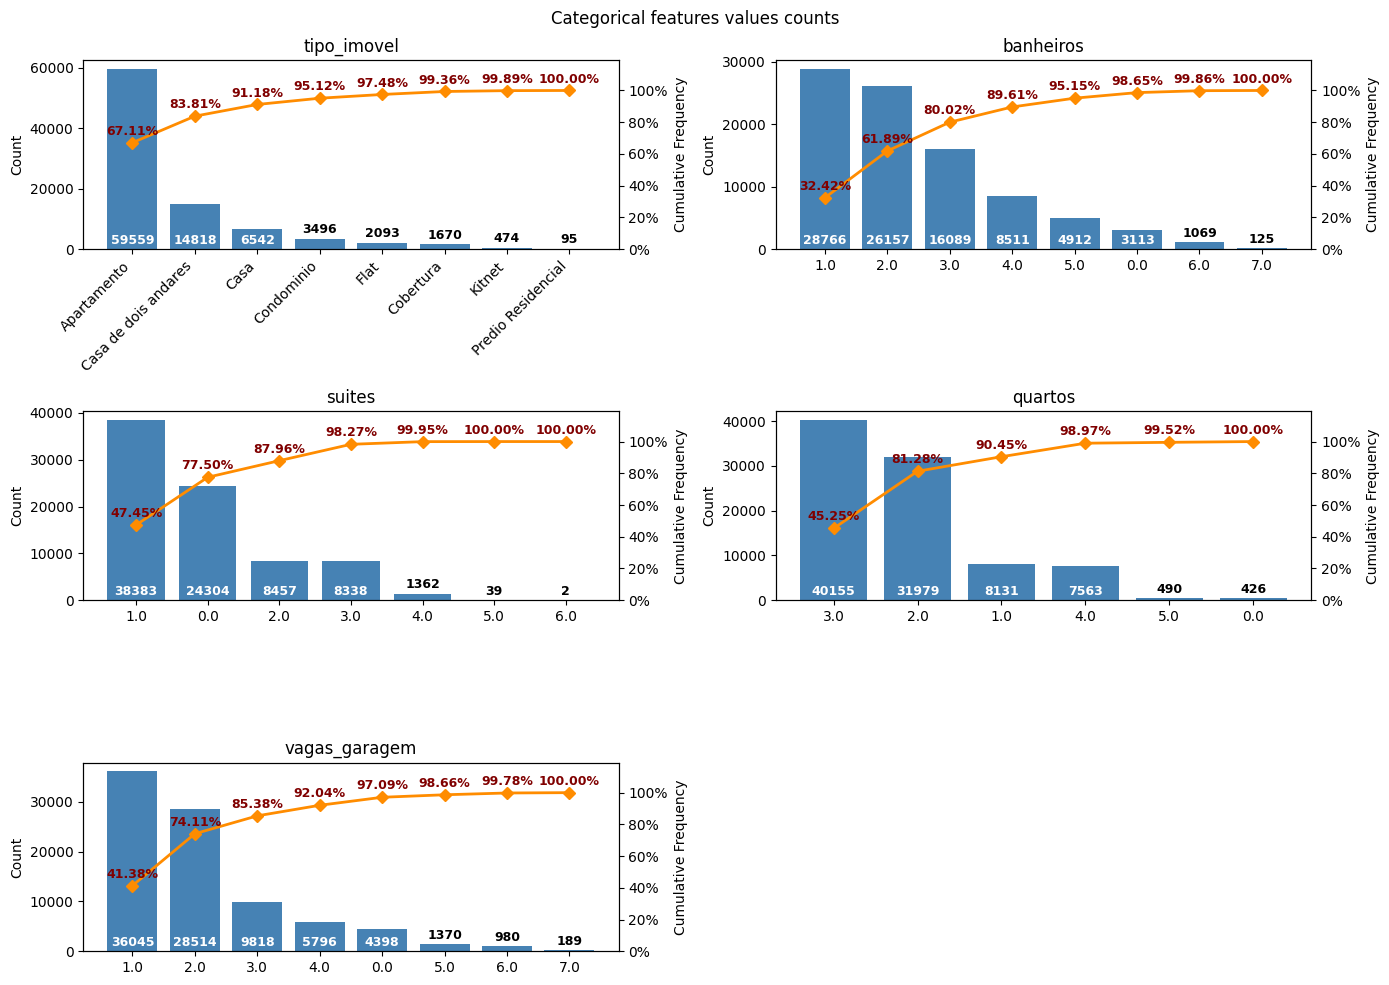

In [11]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14, 10))

axs = [ax for sub in axs for ax in sub]

cat_features = ("tipo_imovel", "banheiros", "suites", "quartos", "vagas_garagem")

for ax, feat in zip(axs, cat_features):
    pareto_chart(feat, sp_house_price, ax=ax)

fig.suptitle("Categorical features values counts")
fig.delaxes(axs[-1])
plt.tight_layout();

From this figure we can conclude that:
- All features have highly unbalanced values.
- 67% of the data corresponds to **apartaments** (**Apartamento**), more than the double of the second most frequent property type (**Case de dois andares**). The number of **Kitnets** and **residential buildings** are diminute w.r.t the other porperty types.
- 62% of the properties have one or two **bathrooms**. Only 3.5% doesn't have a bathroom.
- Less than 1% of the data doesn't have a **bedroom**. 81% of the properties have, at least, 2.
- 47.45% of the data has a **suite**, while 30% doesn't have any **suite**.
- 74% of the properties have one or two **garage spots**. 5% have none.

## Continuous Features

Let's check the distributions of the numeric continuous features: `taxa_condominio`, `iptu_ano` and `area_util`.

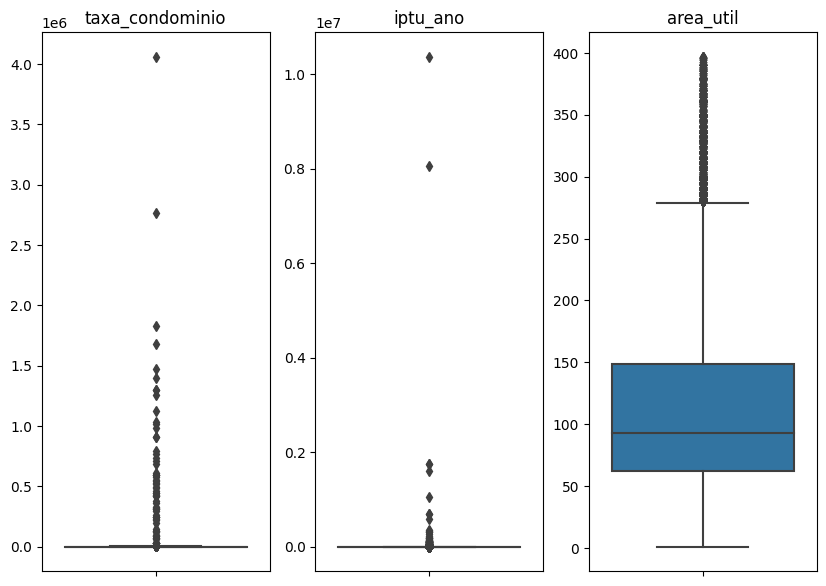

In [12]:
_, axs = plt.subplots(ncols=3, figsize=(10, 7))

for ax, col in zip(axs, ("taxa_condominio", "iptu_ano", "area_util")):
    sns.boxplot(y=col, data=sp_house_price, ax=ax)
    ax.set_ylabel("")
    ax.set_title(col);

These are the main take aways for those features:
- Despite our initial outliers cleaning, `taxa_condominio` and `iptu_ano` still have some values that are very uncommon from others.
- `taxa_condominio` and `iptu_ano` also have a high dispersion, which may be caused by the fact that these features vary with the neighborhood location and house type.
- The porperty area is about 100 m², with 50% of the values ranging between 60 m² to 150 m².

## Missing values

It's time to check on missing values of the dataset. Figure below shows the missing values count for each feature.

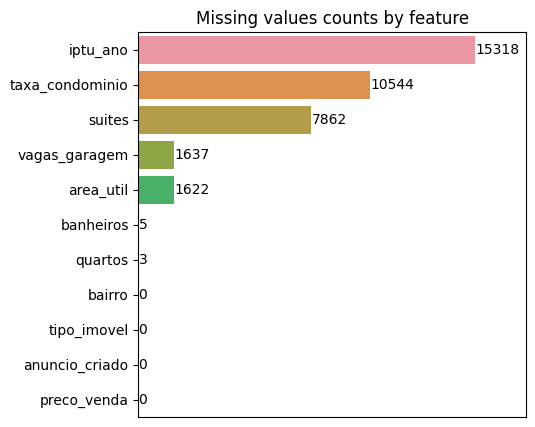

In [13]:
na_counts = sp_house_price.isna().sum(axis="rows").sort_values(ascending=False)

_, ax = plt.subplots(figsize=(5, 5))
sns.barplot(x=na_counts, y=na_counts.index, ax=ax)

for p in ax.patches:
    x = p.get_x()
    y = p.get_y()
    width = p.get_width()
    height = p.get_height()
    ax.annotate(f"{int(width)}", (width + x, y + height * 0.65), ha="left")

ax.set_xlim([0, int(1.15 * na_counts.values[0])])
ax.axes.get_xaxis().set_visible(False)
ax.set_title("Missing values counts by feature");

`iptu_ano` and `taxa_condominio` have the highest missing values counts, followed by `suites`, `vagas_garagem` and `area_util` (which is quite strange).

To better understand those missing values and how these features are affected by them, let's plot the missing values distributions by house type.

In [14]:
def annotated_countplot(col, df, ax=None):
    if not bool(ax):
        _, ax = plt.subplots(figsize=(5, 10))
        
    sns.countplot(y=col, data=df, order=df[col].value_counts().index, ax=ax)

    for p in ax.patches:
        x = p.get_x()
        y = p.get_y()
        width = p.get_width()
        height = p.get_height()
        ax.annotate(f"{int(width)}", (width + x, y + height * 0.65), ha="left")

    max_value = max([p.get_width() for p in ax.patches])
    ax.set_xlim([0, 1.15 * max_value])
    ax.axes.get_xaxis().set_visible(False)
    ax.set_ylabel("")
    ax.set_title(col);

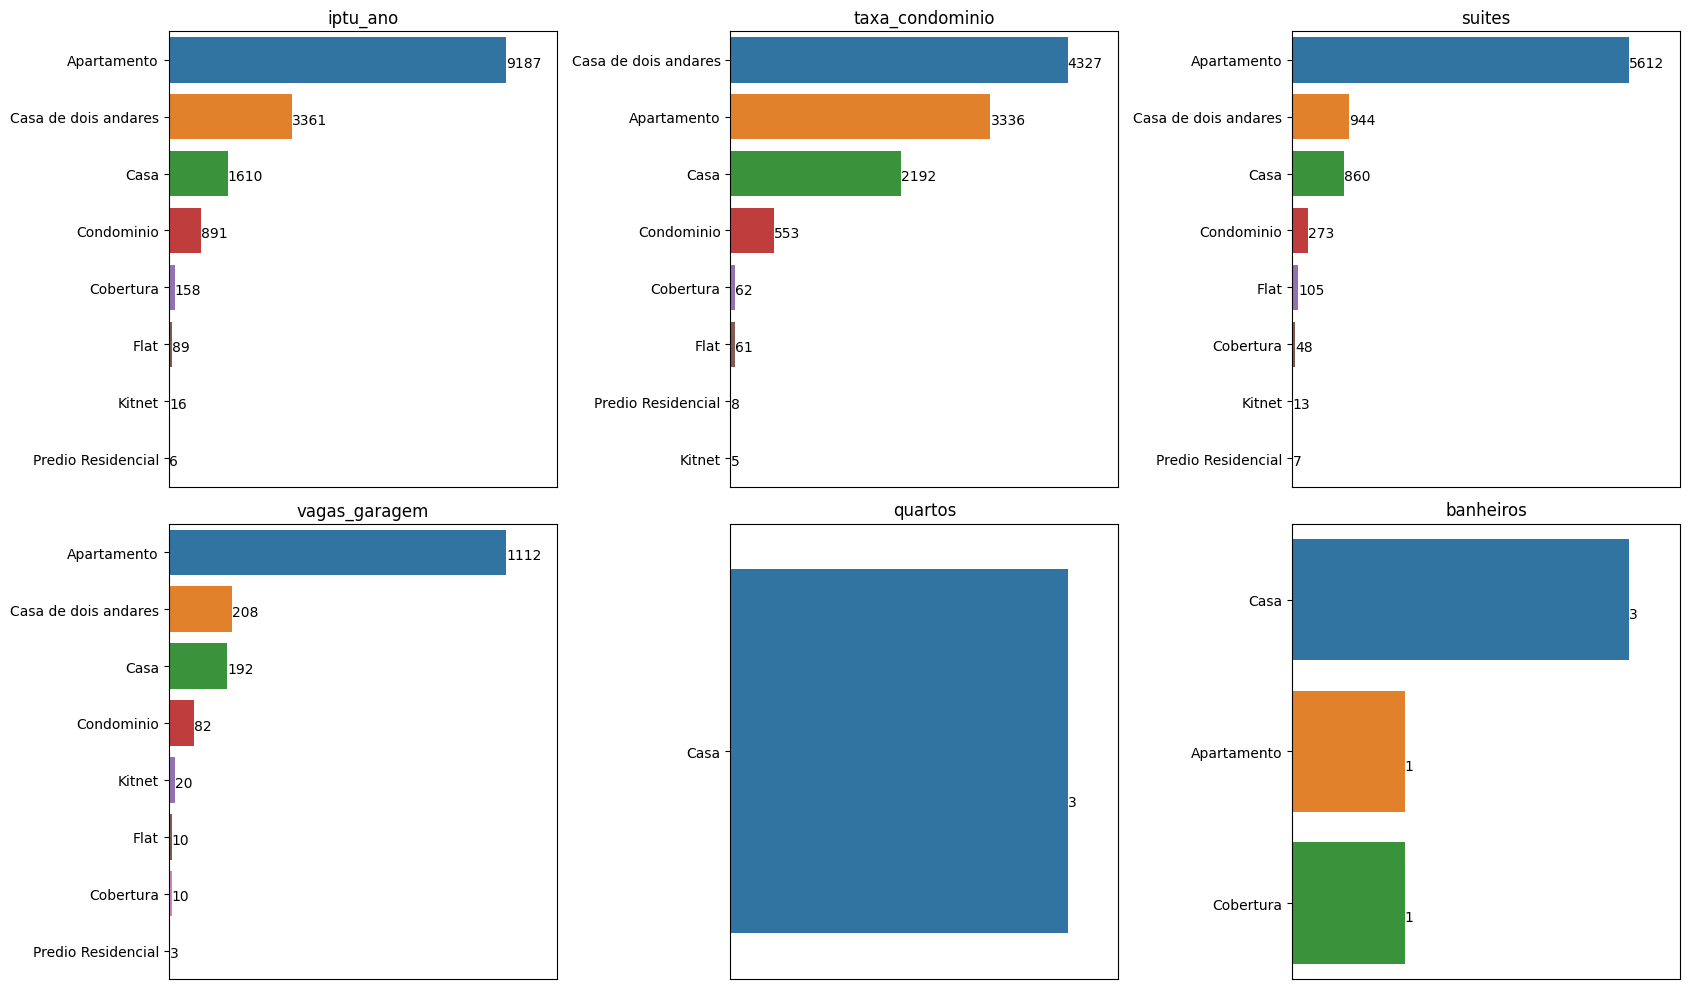

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(17, 10))

axs = [ax for sub in axs for ax in sub]

feats = ("iptu_ano", "taxa_condominio", "suites", "vagas_garagem", "quartos", "banheiros")

for ax, feat in zip(axs, feats):
    view = sp_house_price[sp_house_price[feat].isna()]
    annotated_countplot("tipo_imovel", view, ax=ax)
    ax.set_title(feat)

plt.tight_layout()

- Most of the missing values corresponds to apartments and two store houses, which is pretty reasonable given that these are the most common porperty types. This also supports the theory that moch of these values may be caused by some problems in data collection.
- It's pretty reasonable for a house to not have any `suites` and `vagas_garagem`, so theses missing values aren't much of a problem.
- `quartos` and `banheiros` have both too low number of missing values. The presence of those values won't impact our analisys and future model prediction strategy, so we'll probably drop their respective rows.

# Features Correlations

Now we'll check how each feature is correlated with the houses prices and and with each other.

## Correlation matrix

For the correlation matrix, we'll use numeric features only. The analysis of correlations between categorical features we'll be in the next section.

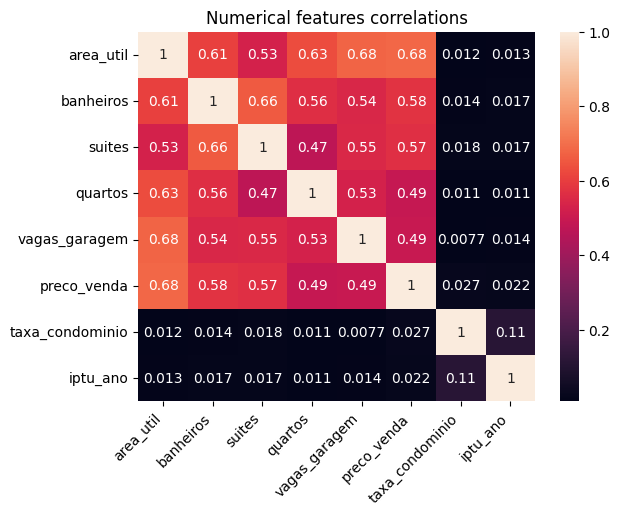

In [21]:
corrs = sp_house_price.select_dtypes(include=("float64", "int64")).corr()

plt.figure()
plt.title("Numerical features correlations")
sns.heatmap(corrs, annot=True)
plt.xticks(rotation=45, ha="right");

- The dataset's house prices are heavily impacted by the property area, number of bathrooms, bedrooms, suites and garage spots.
- At the dataset's current state, the condominium fee and IPTU tax doesn't have much of influence in a house price. This may be due to the high number of of missing values in those features, but we'll leave this analysis for another notebook.
- Some features have a high correlation with each other, like the pairs bedrooms and area; and bathrooms and suites.

## House Price by Neighboor

First of all, we have too many neighboors in this dataset to create a satisfactory visual representation of the correlation of this feature with the house price.

In [22]:
sp_house_price["bairro"].nunique()

1426

So, instead of the house prices distribution of all neighboors we'll plot only for neighboors in the top-50 1and least-50 highest median prices.

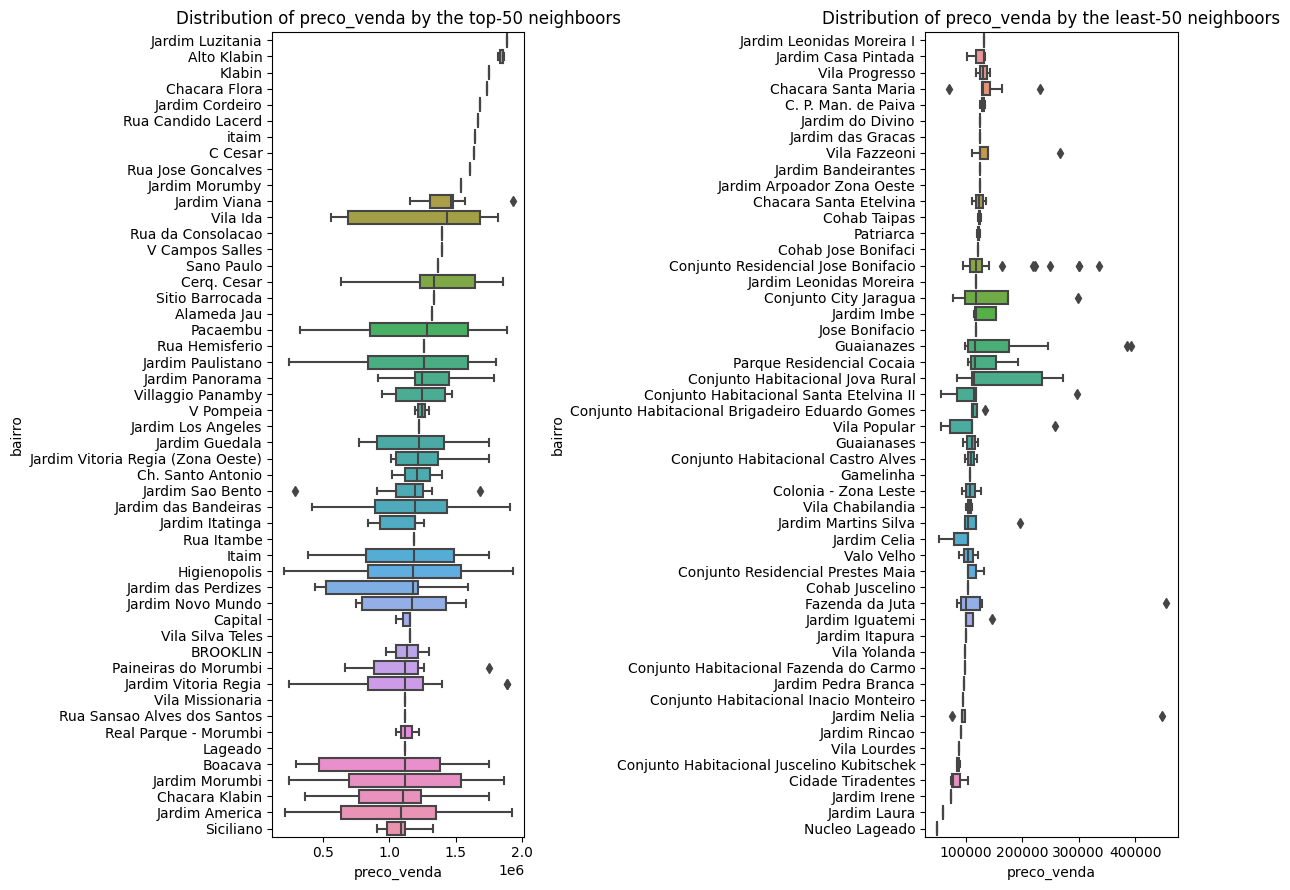

In [23]:
_, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 9))

order = sp_house_price[
    ["bairro", "preco_venda"]
].groupby("bairro").median().squeeze().sort_values(ascending=False)

sns.boxplot(
    x="preco_venda",
    y="bairro",
    data=sp_house_price[sp_house_price["bairro"].isin(order.head(50).index)],
    order=order.head(50).index,
    ax=ax1
)
ax1.set_title("Distribution of preco_venda by the top-50 neighboors")

sns.boxplot(
    x="preco_venda",
    y="bairro",
    data=sp_house_price[sp_house_price["bairro"].isin(order.tail(50).index)],
    order=order.tail(50).index,
    ax=ax2
)
ax2.set_title("Distribution of preco_venda by the least-50 neighboors")

plt.tight_layout()

- The neighboors with the highest and lowest median house prices are, respectively, **Jardim Luzitana** (median price of R$ 1,89 Mi) and **Nucleo Lageado** (median price of R$ 49000,00).
- Much of those neighboors have only 1 property for sale, which explains the lack of variation in house prices.
- Some neighboors can have a high variation in house prices. e.g.: **Pacaembu** have 70 house, which values range from R$ 328000,00 to R$ 1,89 Mi.